In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 2.4
numpy version: 1.17.2
Networkx version: 2.4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.7.0
NumPy version:     1.17.2
Python version:    3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Mon Sep 16 14:19:51 EDT 2019
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 64 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")


import os
print(os.environ['HOME'])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

2.0.0
Using a GPU
/u/yan30


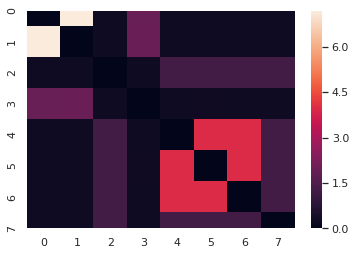

In [241]:
Gorig = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
for u,v,d in Gorig.edges(data=True):
    Gorig[u][v]['weight']=Gorig[u][v]['weight'] + np.random.normal(0,0.001)
H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0).todense()
ax = sns.heatmap(A)

In [6]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_prob(G, k, labels, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = len(G)
    z = labels
    eta = ed.Normal(loc=10, scale=1, name="eta", sample_shape=[k,k]) #beta prior for simple edges
    # parameters to sample the adjacency matrix
    # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
    # very inefficient parameterization
    tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
    tile_a = tf.expand_dims(tile_a, 2) 
    tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
    tile_b = tf.expand_dims(tile_b, 2)
    p = tf.gather_nd(eta, tf.concat([tile_a, tile_b], axis=2))
    #if not selfloops:
    #    TT.set_subtensor(p[np.diag_indices(n)], 0.)
    #if not directed:
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    A = ed.Normal(name = 'A', loc=p, scale=1)
    return A

In [95]:
log_joint = ed.make_log_joint_fn(SBM_prob)
# Function to compute the log posterior probability
n = len(G)
A_obs = tf.convert_to_tensor(nx.to_numpy_array(G), dtype=tf.float32)

#def setParameters(k, label):
k = 3
label = np.random.randint(low = 0, high = 3, size = n) 

def target_log_prob_fn(eta):
  return log_joint(
      G = G,
      k = label.max()+1,
      labels = label,
      eta = eta,
      A=A_obs)

# set initial state (drawn from prior)
peta = tf.random.uniform([k,k], minval=0, maxval=1, dtype=tf.float32)
x = target_log_prob_fn(peta)+305621 #test the target_log_prob_fn with initial state
print(x)
np.exp(-300)

tf.Tensor(-3782.9375, shape=(), dtype=float32)


5.148200222412013e-131

In [101]:
Nsamples = 100  # final number of samples
Nburn = 100     # number of tuning samples

# set up Hamiltonian MC
def sampleMedian(peta, target_log_prob_fn):
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.01,
        num_leapfrog_steps=5)

    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=Nsamples,
        num_burnin_steps=Nburn,
        current_state=[peta],
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        parallel_iterations=100,
        kernel=hmc_kernel)
    return np.median(kernel_results.proposed_results.target_log_prob.numpy()) ##median for posterior estimates
#kernel_results.is_accepted.numpy().mean()

In [251]:
import networkx.algorithms.clique as clique
import itertools as it

def getCandidates(G, labels):
    edgesTop=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
    #percent = int(len(edgesTop)/5000) # adjust for layer size
    eList = [(x[0],x[1]) for x in edgesTop[:10]]
    sub = G.edge_subgraph(eList)
    graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]
    print(len(graphs))
    max_clique_sets = [clique.find_cliques(s) for s in graphs]
    cliques = []
    for clist in max_clique_sets:
        tmp = []
        for c in clist:
            if (len(c)>=2): #(len(c)<=3) and 
                cohesion = 0
                for idx, x in enumerate(c):
                    for idy, y in enumerate(c):
                        if (idy>idx):
                            cohesion = cohesion + G[x][y]['weight']
                tup = (set(c),cohesion/(len(c)-1)/(len(c)-1)) #higher order cliques prioritized
                tmp.append(tup)
        tmp = sorted(tmp, key=lambda t: t[1]) #sort cliques
        cliques += tmp[:3] #keep only top 3 cliques for each component
    
    CliList = sorted(cliques, key=lambda t: t[1])
    print(CliList)
    cliquesFiltered = [x[0] for x in CliList]

    CliXO = {}    
    nodeSet = sorted(set().union(*cliquesFiltered))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(cliquesFiltered):
            if (x in y) and len(CliXO[x])<3: #only top 3 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    combinations = it.product(*(CliXO[Name] for Name in nodeSet))
    Llist = []
    for update in combinations:
        labelsNew = labels.copy()    
        for idx, x in enumerate(update):
            labelsNew[nodeSet[idx]] = len(labels)+x
        b,c =np.unique(labelsNew, return_inverse=True)
        Llist.append(c)
    return Llist

In [109]:
def buildLayer(Gnew, knew, Llist):
    Mlist = []
    A_obs = tf.convert_to_tensor(nx.to_numpy_array(Gnew), dtype=tf.float32)
    for iteration in range (0,len(Llist)):
        label = Llist[iteration]
        def target_log_prob_fn(eta):
          return log_joint(
              G = Gnew,
              k = knew,
              labels = label,
              eta = eta,
              A=A_obs)

        peta = tf.random.uniform([knew,knew], minval=0, maxval=1, dtype=tf.float32)
        Mlist.append(sampleMAP(peta,target_log_prob_fn))

    #Mlist = np.exp(Mlist - max(Mlist))
    #norm = [float(i)/sum(Mlist) for i in Mlist] 
    return sorted(Mlist, reverse = True)

In [247]:
def updateDAG(G, NodeMerge, terms):
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        
    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew) 
    
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [258]:
from collections import Counter
from networkx import relabel

Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
hierarchy = [] # for ddot ontology output
subsystem = 0 # for ddot ontology output
#mapping = [] # for ddot ontology output

while True:
    k = len(Gnew)
    label = np.arange(k)
    print(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    print(ModelPosterior)
    newInternal = [x for x in ModelPosterior[:3]] # only consider top 3 Bayesian assignemtns
    #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
    NodeMerge = [] #nodes to be merged, nested lists of motifs
    for i in range (0,len(newInternal)): #recreate the filtered merges
        newLabel = Llist[i]
        #print(newLabel)        
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        for dupL in dup: 
            nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
            if nodes not in NodeMerge:
                NodeMerge.append(nodes)
                for node in nodes: #update ddot ontology 
                    hierarchy.append((terms[node],"subsystem"+str(subsystem))) #update ddot ontology
                terms[len(terms)] = "subsystem"+str(subsystem)
                subsystem += 1
    print(NodeMerge)
    Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits
    #print(terms)
    print(hierarchy)
    if Gnew.number_of_edges() <=1:
        break    

437
9
[({322, 326}, -0.00447709186514744), ({331, 92}, -0.004040079422299645), ({165, 54}, -0.0037664295782413545), ({226, 118}, -0.003684335487915642), ({185, 287}, -0.003639636518143077), ({99, 22}, -0.0036259828549470388), ({160, 417}, -0.0035549431888048325), ({112, 433}, -0.0035530411129729286), ({184, 353}, -0.0034993158660048553), ({24, 331}, -0.003461306053937489)]
[-6670387.0, -6671340.0]
[[22, 99], [54, 165], [92, 331], [112, 433], [118, 226], [160, 417], [184, 353], [185, 287], [322, 326], [24, 331]]
[('ATF2', 'subsystem0'), ('DNTT', 'subsystem0'), ('CDC25B', 'subsystem1'), ('MEN1', 'subsystem1'), ('DDB2', 'subsystem2'), ('SIRT1', 'subsystem2'), ('EYA3', 'subsystem3'), ('XRCC6BP1', 'subsystem3'), ('FANCB', 'subsystem4'), ('PIAS2', 'subsystem4'), ('MBD4', 'subsystem5'), ('UVRAG', 'subsystem5'), ('MYBBP1A', 'subsystem6'), ('SMG6', 'subsystem6'), ('NABP1', 'subsystem7'), ('RAD51B', 'subsystem7'), ('RRM2B', 'subsystem8'), ('SETMAR', 'subsystem8'), ('ATR', 'subsystem9'), ('SIRT1'

In [259]:
import pickle

with open('hierarchy.save', 'wb') as fp:
    pickle.dump(hierarchy, fp)

In [249]:
terms

{0: 'ACD',
 1: 'ABL1',
 2: 'ACTL6A',
 3: 'ACTR5',
 4: 'ACTR8',
 5: 'ALKBH1',
 6: 'ALKBH2',
 7: 'ALKBH3',
 8: 'AMN1',
 9: 'ANKRD28',
 10: 'ANKRD44',
 11: 'ANKRD52',
 12: 'APEX1',
 13: 'APEX2',
 14: 'APITD1',
 15: 'APLF',
 16: 'APTX',
 17: 'ARID1A',
 18: 'ARID1B',
 19: 'ARID2',
 20: 'ASF1A',
 21: 'ATM',
 22: 'ATRIP',
 23: 'ATRX',
 24: 'BAP1',
 25: 'BARD1',
 26: 'BAZ1A',
 27: 'BAZ1B',
 28: 'BCAS2',
 29: 'BLM',
 30: 'BRCA1',
 31: 'BRCA2',
 32: 'BRCC3',
 33: 'BRD7',
 34: 'BRE',
 35: 'BRIP1',
 36: 'BTG2',
 37: 'CCDC98',
 38: 'CCNA1',
 39: 'CCNA2',
 40: 'CCNB1',
 41: 'CCNB2',
 42: 'CCNB3',
 43: 'CCND1',
 44: 'CCND2',
 45: 'CCND3',
 46: 'CCNE1',
 47: 'CCNH',
 48: 'CCNO',
 49: 'CDC25A',
 50: 'CDK2',
 51: 'CDK4',
 52: 'CDK7',
 53: 'CDKN1A',
 54: 'CDKN2A',
 55: 'CDKN2D',
 56: 'CETN2',
 57: 'CHEK2',
 58: 'CIB1',
 59: 'CLK2',
 60: 'CLSPN',
 61: 'CNOT7',
 62: 'COPS2',
 63: 'COPS3',
 64: 'COPS4',
 65: 'COPS5',
 66: 'COPS6',
 67: 'COPS7A',
 68: 'COPS7B',
 69: 'COPS8',
 70: 'CRY1',
 71: 'CRY2',
 72: 'C

In [255]:
hierarchy

[('ATF2', 'subsystem0'),
 ('DNTT', 'subsystem0'),
 ('CDC25B', 'subsystem1'),
 ('MEN1', 'subsystem1'),
 ('DDB2', 'subsystem2'),
 ('SIRT1', 'subsystem2'),
 ('EYA3', 'subsystem3'),
 ('XRCC6BP1', 'subsystem3'),
 ('FANCB', 'subsystem4'),
 ('PIAS2', 'subsystem4'),
 ('MBD4', 'subsystem5'),
 ('UVRAG', 'subsystem5'),
 ('MYBBP1A', 'subsystem6'),
 ('SMG6', 'subsystem6'),
 ('NABP1', 'subsystem7'),
 ('RAD51B', 'subsystem7'),
 ('RRM2B', 'subsystem8'),
 ('SETMAR', 'subsystem8'),
 ('ATR', 'subsystem9'),
 ('SIRT1', 'subsystem9'),
 ('CSNK1E', 'subsystem10'),
 ('RAD50', 'subsystem10'),
 ('DMC1', 'subsystem11'),
 ('TDG', 'subsystem11'),
 ('EME1', 'subsystem12'),
 ('ZRANB3', 'subsystem12'),
 ('ERCC4', 'subsystem13'),
 ('SMARCAL1', 'subsystem13'),
 ('FANCD2', 'subsystem14'),
 ('TREX2', 'subsystem14'),
 ('INO80C', 'subsystem15'),
 ('PLRG1', 'subsystem15'),
 ('MSH3', 'subsystem16'),
 ('TTI2', 'subsystem16'),
 ('MTOR', 'subsystem17'),
 ('POLK', 'subsystem17'),
 ('PIAS1', 'subsystem18'),
 ('TP53BP1', 'subsystem

In [260]:
Gnew = relabel.convert_node_labels_to_integers(Gnew)
k = len(Gnew)
label = np.arange(k)
print(k)
Llist = getCandidates(Gnew,label)
Llist

1
0
[]


[array([0])]

In [171]:
ModelPosterior = buildLayer(Gnew, k-1, Llist)
print(ModelPosterior)

[-56426.05]


In [172]:
newInternal = [x for x in ModelPosterior[:3]] # only consider top 3 Bayesian assignemtns
#newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
NodeMerge = [] #nodes to be merged, nested lists of motifs
for i in range (0,len(newInternal)): #recreate the filtered merges
    newLabel = Llist[i]
    #print(newLabel)        
    dup = [item for item, count in Counter(newLabel).items() if count > 1]
    for dupL in dup: 
        nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
        if nodes not in NodeMerge:
            NodeMerge.append(nodes)
print(NodeMerge)
Gnew = updateDAG(Gnew, NodeMerge) #update the graph with node mergers/splits

[[37, 38, 39, 40, 41]]


In [164]:
edgesTop=sorted(Gnew.edges(data=True), key=lambda t: t[2].get('weight', 1))
#percent = int(len(edgesTop)/5000) # adjust for layer size
eList = [(x[0],x[1]) for x in edgesTop[:10]]
sub = Gnew.edge_subgraph(eList)
graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]

In [168]:
edgesTop

[(37, 41, {'weight': 0.46338258810827154}),
 (39, 41, {'weight': 0.46342259586930573}),
 (37, 39, {'weight': 0.49452518307424564}),
 (38, 40, {'weight': 0.5027900328758241}),
 (40, 41, {'weight': 0.6104133051269953}),
 (38, 41, {'weight': 0.6104533128880295}),
 (38, 39, {'weight': 0.6174001534933211}),
 (37, 40, {'weight': 0.6177419673970208}),
 (39, 40, {'weight': 0.7107079151081408}),
 (37, 38, {'weight': 0.7111697522949432}),
 (35, 36, {'weight': 0.7413329407797467}),
 (35, 41, {'weight': 0.7420696281628172}),
 (36, 41, {'weight': 0.7425076455300896}),
 (35, 37, {'weight': 0.7556340387417457}),
 (36, 37, {'weight': 0.7565245253711643}),
 (36, 40, {'weight': 0.7624530492320752}),
 (35, 40, {'weight': 0.7626533424112574}),
 (35, 39, {'weight': 0.7795635008568786}),
 (36, 39, {'weight': 0.7804197204186437}),
 (36, 38, {'weight': 0.7863482442795546}),
 (35, 38, {'weight': 0.7865828045263903}),
 (8, 9, {'weight': 0.831431396674901}),
 (8, 18, {'weight': 0.8331954386265357}),
 (8, 36, {'w

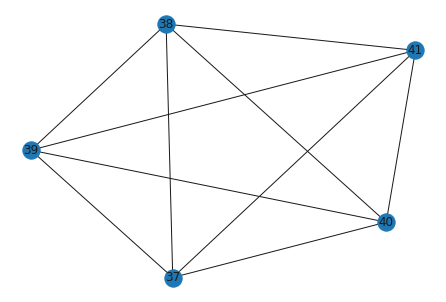

In [167]:
nx.draw(sub, with_labels=True)